In [1]:
import numpy as np
from scipy.sparse import csc_array,csr_array,diags_array
from scipy.sparse import random_array
import matplotlib.pyplot as plt
from scipy.special import expit
from numpy import logaddexp
from tqdm.auto import tqdm
from scipy.optimize import minimize_scalar
from scipy.sparse.linalg import spsolve
import qdldl
from scipy.sparse import block_array
import scipy

In [2]:
from scipy.stats import Uniform


m = 1000
n = 500
samp = Uniform(a = -0.5,b = 0.5).sample


A = random_array((m,n),density = 0.2,data_sampler = lambda size:samp(size))
x_true = np.random.uniform(-0.1,1,n)

z_true = A@x_true

w = 100*np.ones(m)
y = np.random.binomial(w.astype(int),expit(z_true))/w

Q = 100 * diags_array(np.ones(n))

In [3]:
class LogisticNLL:
    def __init__(self, y, w):
        """
        y: array-like of binary responses (0 or 1)
        w: array-like of corresponding weights
        """
        self.y = np.array(y, dtype=float)
        self.w = np.array(w, dtype=float)

    def f(self, z):
        """
        Computes the negative weighted logistic log-likelihood:
            sum_i w_i [ log(1 + exp(z_i)) - y_i * z_i ]
        """
        z = np.array(z, dtype=float)
        return np.sum(self.w * (logaddexp(0, z) - self.y * z))

    def d1f(self, z):
        """
        Computes the first derivative (gradient) w.r.t. z:
            w_i [ sigma(z_i) - y_i ]
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        return self.w * (sig_z - self.y)

    def d2f(self, z):
        """
        Computes the second derivative (Hessian diagonal) w.r.t. z:
            w_i * sigma(z_i) * (1 - sigma(z_i))
        also using expit(z) for numerical stability.
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        hess_diag = self.w * sig_z * (1.0 - sig_z)
        return hess_diag

    def __call__(self, z):
        """
        By defining __call__, this object can be used like a function:
            phi(z) = phi.f(z)
        """
        return self.f(z)

In [4]:
def get_step_size(s, ds, y, dy,frac = 0.99):
    """
    Returns stepsize
      s + alpha*ds > 0  and  lam + alpha*dlam > 0
    for all components. with safety factor of frac
    """    
    # For s + alpha*ds > 0  =>  alpha < -s[i] / ds[i] for ds[i] < 0
    idx_s_neg = ds < 0
    if np.any(idx_s_neg):
        alpha_s = np.min(-s[idx_s_neg] / ds[idx_s_neg])
    else:
        alpha_s = np.inf  # If ds >= 0, it doesn't limit alpha
    
    # For y + alpha*dy > 0  =>  y < -y[i] / dy[i] for dy[i] < 0
    idx_y_neg = dy < 0
    if np.any(idx_y_neg):
        alpha_lam = np.min(-y[idx_y_neg] / dy[idx_y_neg])
    else:
        alpha_lam = np.inf
    
    # Final step size is the minimum of those bounds and 1.0 (common practice),
    # possibly multiplied by a safety factor like 0.99 if desired.
    alpha = min(frac*alpha_s, frac*alpha_lam, 1.0)
    return alpha


In [ ]:
def solve_glm(f,A,Q,C,c,x0 = None,y0 = None,b = None, lam = 1.):
    """
    Every piece of this is delicate
    in getting good performance. 

    Line search to handle objective is a pain
    """
    max_precenter = 50
    max_iter = 100
    subproblem_tol = 1e-6
    ip_frac = 0.2
    mu_target = 1e-7
    tol = 1e-7
    boundary_frac = 0.98
    gamma = 0.5
    min_mu = 1e-10
    tau_reg = 1e-10

    m = A.shape[0]
    n = A.shape[1]

    k = C.shape[0]
    print(f"{k} constraints")
    print(f"{n} variables")
    print(f"{m} rows in A")
    assert A.shape[1] == C.shape[1]
    assert C.shape[0] == len(c)

    if x0 is None:
        x = np.zeros(n)
    else:
        x = np.copy(x0)
    
    if y0 is None:
        y = np.ones(k)
    else:
        y = np.copy(y0)
        assert np.min(y)>0
    
    if b is None:
        b = np.zeros(n)
    
    s = np.ones(k)
    def KKT_res(x,g,y,s,mu):
        rx = C.T@y - b + g
        rp = C@x + s - c
        rc = y * s - mu*np.ones(k)
        return rx,rp,rc
    
    Ik = diags_array(np.ones(k))   
    In = diags_array(np.ones(n))     
    def solve_KKT(x,y,s,H,rx,rp,rc,mu,solver = None):
        #Nesterov-Todd scaling and do quasi-definite
        # Quasi definite for inequality constraints, 
        # "normal equations" Hessian for GLM part
        w = np.sqrt(y/s)
        wC = C.multiply(w[:,None])
        G = block_array(
            [
                [H+tau_reg*In,wC.T],
                [wC,-Ik]
            ],format = 'csc'
        )
        rhs = np.hstack([-rx,-w*rp + (w/y) * rc])
        if solver is None:
            solver = qdldl.Solver(G)
        else:
            solver.update(G)
        sol = solver.solve(rhs)
        dx = sol[:n]
        dy = w*sol[n:]
        ds = -rp - C@dx
        return dx,ds,dy,solver
    
    def get_H(z):
        D = f.d2f(z)[:,None]
        return A.T@A.multiply(D) + Q

    
    #Phase 1 to obtain feasibility
    # simple QP acts a precentering step
    z = A@x
    Hf = get_H(z)

    gradf = A.T@f.d1f(z)
    H = diags_array(np.ones(n)) + Hf
    mu = 1.
    solver = None
    for i in range(max_precenter):
        #Gradient of the objective (without the b tilt)
        g = H@x + gradf
        rx,rp,rc = KKT_res(x,g,y,s,mu)
        kkt_res = np.max(
            np.abs(np.hstack([rx,rp,rc]))
        )
        primal_violation = np.max(np.abs(rp))
        if primal_violation<=1e-8 and kkt_res<=1e-2:
            break
        dx,ds,dy,solver = solve_KKT(x,y,s,H,rx,rp,rc,mu,solver)
        t = get_step_size(s,ds,y,dy,frac = boundary_frac)
        x = x + t*dx
        s = s + t*ds
        y = y + t*dy
    print(f"Finished centering in {i} iterations")
    
    def merit_line(t,x,dx,mu):
        return f(A@(x+t*dx))#-mu*np.sum(np.log(c - C@(x+t*dx)))

    #Phase 2 to fit model
    for i in range(max_iter):
        print("______________________________")
        print(f"Iteration {i}")
        z = A@x
        H = get_H(z)
        gradf = A.T@f.d1f(z) + Q@x
        rx,rp,rc = KKT_res(x,gradf,y,s,mu)
        kkt_res = np.max(
            np.abs(np.hstack([rx,rp,rc+ mu*np.ones(k)]))
        )
        print("mu,KKTres", mu,kkt_res)
        if kkt_res<=tol:
            break
        
        dx,ds,dy,solver = solve_KKT(x,y,s,H,rx,rp,rc,mu,solver)
        tmax = get_step_size(s,ds,y,dy,frac = boundary_frac)
        m0 = merit_line(0.,x,dx,mu)
        t = tmax
        for i in range(10):
            mt = merit_line(t,x,dx,mu)
            if mt<m0:
                break
            else:
                t = 0.8*t
        print("t,merit_dec",t,mt - m0)
        x = x + t*dx
        s = s + t*ds
        y = y + t*dy

        if kkt_res<=50* mu:
            mu_est = np.dot(s,y)/k
            xi = np.min(s*y)/mu_est
            mu = np.maximum(np.maximum(mu/10,min_mu),gamma * np.minimum(
                (1-boundary_frac)*(1-xi)/xi + 0.1,2
            )**3 * mu_est)
            print("(1-xi)/xi = ",(1-xi)/xi)
            print("xi",xi)
            print("min term", np.minimum(
                (1-boundary_frac)*(1-xi)/xi,2
            ))

    return x


In [230]:
rng = np.random.default_rng(10)

xx = rng.normal(size = n)
samp = Uniform(a = -0.5,b = 0.5).sample

C = random_array((200,n),
                 density = 0.2,rng = rng)

c = C@xx + 0.01
Q = diags_array(np.ones(n))
f = LogisticNLL(y,w)

In [231]:
x = solve_glm(f,A,Q,C,c)

200 constraints
500 variables
1000 rows in A
Finished centering in 9 iterations
______________________________
Iteration 0
mu,KKTres 1.0 97.56040691826402
t,merit_dec 0.718125683912938 -520.8586167063331
______________________________
Iteration 1
mu,KKTres 1.0 32.96199915146288
t,merit_dec 1.0 -81.83244320409722
(1-xi)/xi =  0.210016977378501
xi 0.8264346853764793
min term 0.004200339547570023
______________________________
Iteration 2
mu,KKTres 0.1 2.9490738676294566
t,merit_dec 0.9781108808769766 -49.99504942749627
(1-xi)/xi =  6.089149229722186
xi 0.1410606502409865
min term 0.12178298459444382
______________________________
Iteration 3
mu,KKTres 0.01 0.40249196612450205
t,merit_dec 0.9723184376521489 -4.957223070348846
(1-xi)/xi =  2.2131967738795986
xi 0.31121654550667455
min term 0.04426393547759201
______________________________
Iteration 4
mu,KKTres 0.001 0.08621991339471739
t,merit_dec 1.0 -0.7055525356845465
______________________________
Iteration 5
mu,KKTres 0.001 0.0199768

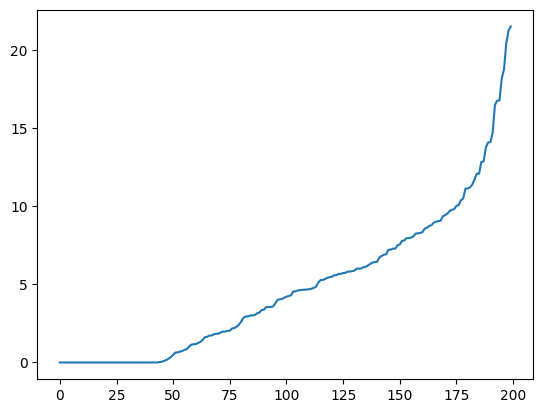

In [232]:
plt.plot(np.sort(c - C@x))

In [233]:
import cvxpy as cp
n = A.shape[1]

beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
neg_log_likelihood = cp.sum(
    cp.multiply(w,cp.logistic(A @ beta)- cp.multiply(y, A @ beta))
)
regularization = beta.T@Q@beta/2

problem  = cp.Problem(cp.Minimize(
    (neg_log_likelihood + regularization)),[C @ beta <= c]
)
problem.solve(verbose = True)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Apr 16 10:28:18 PM: Your problem has 500 variables, 200 constraints, and 0 parameters.
(CVXPY) Apr 16 10:28:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 16 10:28:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 16 10:28:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 16 10:28:18 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 16 10:28:18 PM: Compiling problem (target solver=CLARABEL

69428.5322673454

In [234]:
print(f(A@x) + (1/2) *x.T@Q@x)
print(problem.value)

69428.53226458075
69428.5322673454


In [235]:
print(problem.value -f(A@x) - (1/2) *x.T@Q@x)

2.764656159115475e-06
